# Imports

In [1]:
import pandas as pd
import numpy as np
 
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate
from tensorflow.keras.layers import Dropout, Dense, Lambda, Multiply, Subtract, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam


# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Text preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
import random
import time
from tqdm import tqdm_notebook as tqdm
import pretty_midi

SEED = 42
%matplotlib inline

# Load Data

### Load raw data

In [17]:
cols = ['Singer', 'Song Name', 'Lyrics']

df = pd.read_csv('datasets/lyrics_train_set.csv', names=cols)
df_test = pd.read_csv('datasets/lyrics_test_set.csv', names=cols)

### Add midi files' names

In [16]:
def add_midi_files(df):
    midis = list(os.listdir(r'./datasets/midi_files'))
    midis = {midi.lower()[:-4]: midi for midi in midis}    
    
    def combine_singer_song(singer, song):
        key = f'{singer} - {song}'.replace(' ', '_').lower()
        return midis[key] if key in midis else None
    
    df['Midi File'] = df.apply(lambda r: combine_singer_song(r['Singer'], r['Song Name']) ,axis=1)
    return df
    

In [ ]:
df = add_midi_files(df)
df_test = add_midi_files(df_test)

#### check midi files

In [22]:
midis = np.concatenate([df['Midi File'].values, df_test['Midi File'].values])
midis.shape

(620,)

In [24]:
corrupted = []
for i, midi in enumerate(midis):
    try:
        midi = pretty_midi.PrettyMIDI(fr'./datasets/midi_files/{midi}')
        midi.remove_invalid_notes()
        del midi
    except Exception as e:
        print("%s\nerror readying midi file %s" % (e, midi))
        corrupted.append(i)

Could not decode key with 16 sharps and mode 1
error readying midi file David_Bowie_-_Lazarus.mid
Could not decode key with 1 flats and mode 255
error readying midi file Beastie_Boys_-_Girls.mid
data byte must be in range 0..127
error readying midi file Billy_Joel_-_Movin'_Out.mid
data byte must be in range 0..127
error readying midi file Billy_Joel_-_Pressure.mid
Could not decode key with 4 flats and mode 255
error readying midi file Dan_Fogelberg_-_Leader_of_the_Band.mid

error readying midi file Brian_McKnight_-_On_The_Down_Low.mid
data byte must be in range 0..127
error readying midi file Aaron_Neville_-_Tell_It_Like_It_Is.mid


In [26]:
print(f'The folowing files index are corrupted: {corrupted}')

The folowing files index are corrupted: [91, 115, 136, 143, 189, 513, 575]


In [27]:
df.iloc[corrupted]

,Singer,Song Name,Lyrics,Midi File
91,david bowie,lazarus,look up here i'm in heaven & i've got scars th...,David_Bowie_-_Lazarus.mid
115,beastie boys,girls,girls all i really want is girls & and in the ...,Beastie_Boys_-_Girls.mid
136,billy joel,movin' out,anthony works in the grocery store & savin h...,Billy_Joel_-_Movin'_Out.mid
143,billy joel,pressure,you have to learn to pace yourself & pressure ...,Billy_Joel_-_Pressure.mid
189,dan fogelberg,leader of the band,an only child alone and wild a cabinet maker's...,Dan_Fogelberg_-_Leader_of_the_Band.mid
513,brian mcknight,on the down low,maxine was 5'9'' & had a man and she didn't mi...,Brian_McKnight_-_On_The_Down_Low.mid
575,aaron neville,tell it like it is,if you want something to play with & go and fi...,Aaron_Neville_-_Tell_It_Like_It_Is.mid


In [30]:
df = df[~df.index.isin(corrupted)]

### Create Validation Dataset

In [211]:
msk = np.random.rand(len(df)) < 0.8

df_train = df[msk]
df_val = df[~msk]

# Preprocessing

## Lyrics preprocessing

In [159]:
l = df_train.iloc[0, 2]
l

'goodbye norma jean & though i never knew you at all & you had the grace to hold yourself & while those around you crawled & they crawled out of the woodwork & and they whispered into your brain & they set you on the treadmill & and they made you change your name & and it seems to me you lived your life & like a candle in the wind & never knowing who to cling to & when the rain set in & and i would liked to have known you & but i was just a kid & your candle burned out long before & your legend ever did & loneliness was tough & the toughest role you ever played & hollywood created a superstar & and pain was the price you paid & even when you died & oh the press still hounded you & all the papers had to say & was that marilyn was found in the nude & and it seems to me you lived your life & like a candle in the wind & never knowing who to cling to & when the rain set in & and i would liked to have known you & but i was just a kid & your candle burned out long before & your legend ever di

In [160]:
from nltk.tokenize import word_tokenize

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"in\'", "ing", phrase)
    phrase = re.sub(r"y\'all", "you all", phrase)
    
    # punctions
    regex = re.compile('[^a-zA-Z& ]')
    phrase = regex.sub('', phrase)
    
    return phrase

def preprocess_lyrics(data):
    data = decontracted(data)
    tokens = word_tokenize(data)
    data_arr = []
    
    for t in tokens:
        # Use only words, character combinations and numbers 
#         if not t.isalpha(): 
#             continue
            
        # Lower case word
        t = t.lower()
        
#         # Remove stop words
#         if t in sw: 
#             continue
        
        data_arr.append(t)
    
    
    return data_arr

In [161]:
df_train.iloc[8,2]

"it's not time to make a change   & just relax take it easy   & you're still young that's your fault   & there's so much you have to know   & find a girl settle down   & if you want you can marry   & look at me i am old but i'm happy   &    & i was once like you are now   & and i know that it's not easy   & to be calm when you've found   & something going on   & but take your time think a lot   & think of everything you've got   & for you will still be here tomorrow   & but your dreams may not   &    & how can i try to explain?   & when i do he turns away again   & it's always been the same same old story   & from the moment i could talk   & i was ordered to listen   & now there's a way   & and i know that i have to go away   & i know i have to go   &    & it's not time to make a change   & just sit down take it slowly   & you're still young that's your fault   & there's so much you have to go through   & find a girl settle down   & if you want you can marry   & look at me i am old but

In [162]:
string = df_train.iloc[8,2]
tokenized_string = preprocess_lyrics(string)

def pretty_lyrics(tokenized_string):
    for token in tokenized_string:
        if token == '&':
            print('\n')
        else:
            print(token, end=' ')

pretty_lyrics(tokenized_string)

it is not time to make a change 

just relax take it easy 

you are still young that is your fault 

there is so much you have to know 

find a girl settle down 

if you want you can marry 

look at me i am old but i am happy 



i was once like you are now 

and i know that it is not easy 

to be calm when you have found 

something going on 

but take your time think a lot 

think of everything you have got 

for you will still be here tomorrow 

but your dreams may not 



how can i try to explain 

when i do he turns away again 

it is always been the same same old story 

from the moment i could talk 

i was ordered to listen 

now there is a way 

and i know that i have to go away 

i know i have to go 



it is not time to make a change 

just sit down take it slowly 

you are still young that is your fault 

there is so much you have to go through 

find a girl settle down 

if you want you can marry 

look at me i am old but i am happy 



all the times that i have cried 

kee

In [164]:
stop_token = '$'
lyrics_train = df_train['Lyrics'].apply(lambda s: preprocess_lyrics(s)[:-1] + [stop_token])
lyrics_val = df_val['Lyrics'].apply(lambda s: preprocess_lyrics(s)[:-1] + [stop_token])


3      [come, on, check, it, out, ya, will, &, come, ...
4      [let, the, beat, control, your, body, &, let, ...
7      [now, that, i, have, lost, everything, to, you...
11     [now, i, have, been, happy, lately, &, thinkin...
24     [woohoo, &, woohoo, &, woohoo, &, woohoo, &, i...
                             ...                        
596    [hi, my, name, is, what, &, my, name, is, who,...
597    [whatever, &, dre, just, let, it, run, &, ey, ...
600    [okay, &, i, am, going, to, attempt, to, drown...
603    [meet, eddie, twentythree, years, old, &, fed,...
614    [you, all, know, me, still, the, same, og, but...
Name: Lyrics, Length: 113, dtype: object

### Create embeddings

In [166]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lyrics_train)

In [167]:
lyrics_train = tokenizer.texts_to_sequences(lyrics_train)
lyrics_val = tokenizer.texts_to_sequences(lyrics_val)

In [170]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin'

if not os.path.isfile(EMBEDDING_FILE):
    !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
    !gzip -f -d GoogleNews-vectors-negative300.bin.gz

In [171]:
from gensim import models

embeddings_index = models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
embed_size = 300
word_index = tokenizer.word_index
max_features = len(word_index) + 1

nb_words = len(word_index)
embedding_matrix = (np.random.rand(nb_words+1, embed_size) - 0.5) / 5.0

not_in_word2vec = 0
for word, i in word_index.items():
    if i >= max_features: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix[i] = embedding_vector
    else:
        not_in_word2vec += 1
        
print(f'{not_in_word2vec} out of {len(word_index)} has no embedings from word2vec')

541 out of 6377 has no embedings from word2vec


#### Trying one word to whole song but one word

In [115]:
# train_x, train_y = [], []

# for lyric in lyrics:
#     for i in range(1, len(lyric)):
#         train_x.append(lyric[:i])
#         train_y.append(*lyric[i:i+1])
        
# train_x = pad_sequences(train_x)
# train_y = to_categorical(train_y)
# train_x.shape, train_y.shape

((156330, 1204), (156330, 6670))

#### Trying sliding window of words

In [172]:
ast=np.lib.index_tricks.as_strided
def generate_sliding_window(arr, window_size=5, window_stride=1, last_window=False):
    last_window = 1 if last_window else 0
    arr = np.ascontiguousarray(arr)
    arr_len = arr.shape[0]
    s, = arr.strides
    windows_num = ((arr_len-window_size)//window_stride) + last_window
    
    return ast(arr, (windows_num, window_size), (s*window_stride, s))

In [196]:
def split_x_y(lyrics, window_size=10):
    X, y = [], []
    for lyric in lyrics:
        X.append(generate_sliding_window(lyric, window_size))
        y.append(lyric[window_size:])
        
    X = np.concatenate(X)
    y = to_categorical(np.concatenate(y), num_classes=max_features)
    
    return X,y


In [197]:
window_size = 13
train_data = split_x_y(lyrics_train, window_size)
val_data = split_x_y(lyrics_val, window_size)

## Melody preprocessing

In [31]:
def preprocess_melody_file(path):
    pm = pretty_midi.PrettyMIDI('datasets/midi_files/aladdin_-_A_whole_new_world.mid')
    pm.remove_invalid_notes()
    
    return pm.get_piano_roll()

<AxesSubplot:>

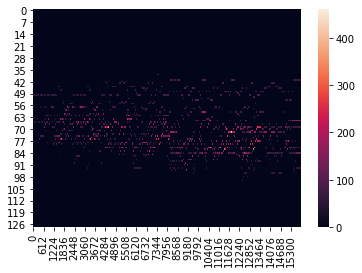

In [34]:
sns.heatmap(preprocess_melody_file('datasets/midi_files/aladdin_-_A_whole_new_world.mid'))

In [9]:
pm = pretty_midi.PrettyMIDI('datasets/midi_files/aladdin_-_A_whole_new_world.mid')
pm

In [12]:
pm.remove_invalid_notes()

In [139]:
print('There are {} time signature changes'.format(len(pm.time_signature_changes)))
print('There are {} instruments'.format(len(pm.instruments)))
print('Instrument 3 has {} notes'.format(len(pm.instruments[0].notes)))
print('Instrument 4 has {} pitch bends'.format(len(pm.instruments[4].pitch_bends)))
print('Instrument 5 has {} control changes'.format(len(pm.instruments[5].control_changes)))

There are 1 time signature changes
There are 9 instruments
Instrument 3 has 227 notes
Instrument 4 has 0 pitch bends
Instrument 5 has 0 control changes


# Building the Lyrics Generator model

In [200]:
def init_simple(seq_len):
    inp = Input(shape=(seq_len,))
    
    embd = Embedding(max_features, 
                      embed_size, 
                      weights=[embedding_matrix],
                      input_length=seq_len,
                      name='word_embd')(inp)
    
    lstm = LSTM(100, return_sequences=True)(embd)
    lstm = LSTM(100)(lstm)

    X = Dense(100, activation="relu")(lstm)
    X = Dropout(0.5)(X)
    out = Dense(max_features, activation="softmax", name = 'out')(X)

    model = Model(inp, out)
    
#     model.get_layer('embd').trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    
    return model

In [201]:
def get_callbacks(model_name):
    acc = 'val_loss'
    acc_mode = 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=6)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR] #earlystop

In [203]:
def train_model(model_gen, train_data, val_data, use_saved=False, params_dict=None):
    os.makedirs('./models', exist_ok=True)
    params = ''
    if params_dict is not None:
        params = '_'.join(f'{key}_{val}' for key,val in params_dict.items())
    model_name = model_gen.__name__[5:] + f'_{params}'
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
        
        train_x, train_y = train_data
        
        model = model_gen(train_x.shape[1]) # window size
        history = model.fit(
                            x=train_x,
                            y=train_y,
                            batch_size=params_dict['batch_size'],
                            epochs=params_dict['epochs'],
                            validation_data=val_data,
                            callbacks=callbacks,
                            verbose=1
                            )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')
    
    return model, history

In [204]:
model = init_simple(train_x.shape[1])
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1204)]            0         
_________________________________________________________________
word_embd (Embedding)        (None, 1204, 300)         1913400   
_________________________________________________________________
lstm_17 (LSTM)               (None, 1204, 100)         160400    
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
out (Dense)                  (None, 6378)              644

In [205]:
params_dict = {'batch_size': 32, 'epochs': 20}
model, history= train_model(init_simple, train_data, val_data, use_saved=F, params_dict=params_dict)

Epoch 1/20
4619/4619 [==============================] - 86s 17ms/step - loss: 5.7913 - val_loss: 5.0301
Epoch 2/20
4619/4619 [==============================] - 70s 15ms/step - loss: 4.9867 - val_loss: 4.8607
Epoch 3/20
4619/4619 [==============================] - 69s 15ms/step - loss: 4.6565 - val_loss: 4.8774
Epoch 4/20
4619/4619 [==============================] - 76s 16ms/step - loss: 4.4195 - val_loss: 4.9408
Epoch 5/20
4619/4619 [==============================] - 76s 16ms/step - loss: 4.2456 - val_loss: 5.0937
Epoch 6/20
4619/4619 [==============================] - 77s 17ms/step - loss: 4.0573 - val_loss: 5.2618
Epoch 7/20
4619/4619 [==============================] - 76s 17ms/step - loss: 3.9183 - val_loss: 5.4201
Epoch 8/20
4619/4619 [==============================] - 76s 16ms/step - loss: 3.7498 - val_loss: 5.7651
Epoch 9/20
4619/4619 [==============================] - 75s 16ms/step - loss: 3.6126 - val_loss: 5.9113
Epoch 10/20
4619/4619 [==============================] - 77s 17m

# Sample Lyrics by Seed

In [ ]:
def generate_song(model, seed, window_size, stop_token, tokenizer, max_len):
    stop_token = tokenizer.word_index[stop_token]
    
    def get_next_word(seed):
        probs = model.predict(seed)
        chosen_idx = np.random.choice(range(0, max_features), p=probs[0])
        chosen_word = tokenizer.sequences_to_texts([[chosen_idx]])[0]
        
        return chosen_idx, chosen_word
    
    
    seed = preprocess_lyrics(seed)
    song = seed.copy()
    seed = ' '.join(seed)
    seed = tokenizer.texts_to_sequences([seed])
    seed = pad_sequences(seed, maxlen=window_size)

    i = 0
    idx, word = get_next_word(seed)
    while word != stop_token and i < max_len:
        song.append(word)
        i+=1
        seed = np.concatenate([seed[:,1:], [[idx]]], axis=1)
        idx, word = get_next_word(seed)
    
    return song    

In [ ]:
song_max_length = 2000
seed = 'Smack that all on the floor'
song = generate_song(model, seed, window_size, stop_token, tokenizer, song_max_length)
pretty_lyrics(song)